In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
model_save_dir = "/kaggle/working/"
os.makedirs(model_save_dir, exist_ok=True)

In [3]:
# Define transformations for the training and validation data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Use ImageFolder to load datasets from the directories
train_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/train', transform=train_transforms)
val_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/val', transform=val_transforms)
test_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/test', transform=val_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load pre-trained ResNet50 model and modify the final layer for 36 classes
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 35)  # 35 classes: A-Z (excluding J, Z) + 1-9

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


In [6]:
# Move the model to the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)


In [ ]:
# Training loop
num_epochs = 50
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation step
    resnet50.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

    # Save the model for this epoch
    torch.save(resnet50.state_dict(), os.path.join(model_save_dir, f'resnet50_epoch_{epoch+1}.pth'))

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet50.state_dict(), os.path.join(model_save_dir, 'resnet50_best_model.pth'))

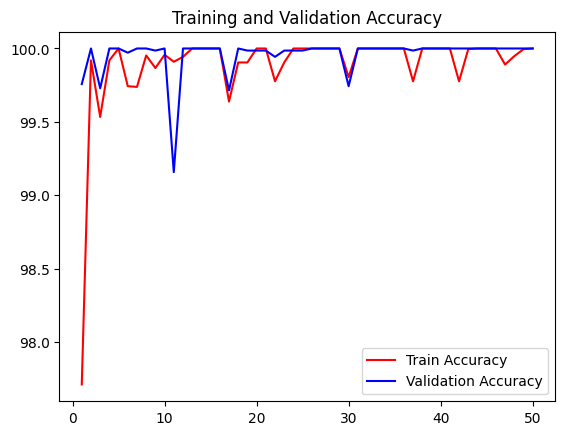

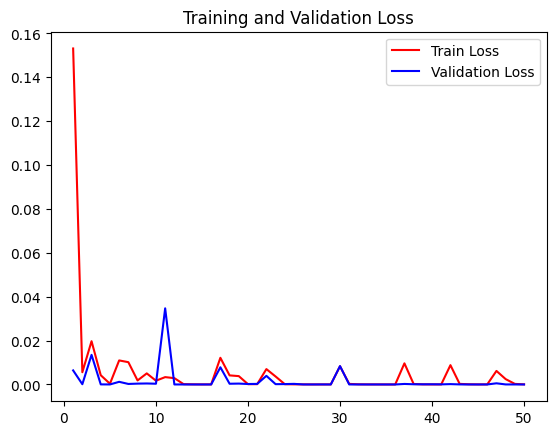

In [8]:
# Plot accuracy and loss
epochs = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs, train_acc_history, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, train_loss_history, 'r', label='Train Loss')
plt.plot(epochs, val_loss_history, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


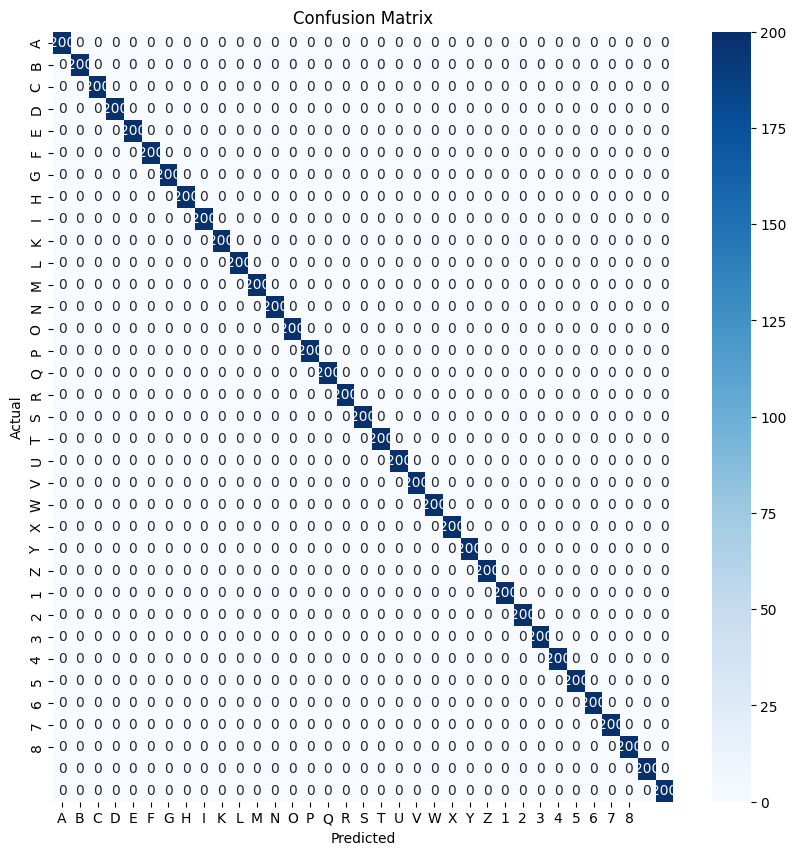

In [9]:
# Evaluation on test set and metrics calculation
resnet50.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Confusion Matrix
classes = [chr(i) for i in range(65, 91) if i != 74] + [str(i) for i in range(1, 10) if i != 9]  # A-Z (no J), 1-9 (no Z)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()